# Surnjani Djoko May 12th 2022
## Process the train dataset and perform evaluation based on local model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_train = pd.read_csv('full_sample/data_set1_train.clean_1.csv')
df_train.shape, display(df_train.head(3))

,date,year,month,day,publication,title_article_cleaned
0,2016-10-07 21:26:46,2016,10.000,7,Business Insider,colt gm ryan grigson andrew luck contract diff...
1,2016-01-27 00:00:00,2016,1.000,27,TMZ,pari hilton woman black uncl monti funer pari ...
2,2016-05-18 13:00:06,2016,5.000,18,Vox,watch googl io keynot live googl io compani bi...


((2067317, 6), None)

In [3]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

In [4]:
# load back the entire training corpus and dictionary
DICT_PATH="full_sample/id2word_50k_filtered_full"
CORPUS_PATH="full_sample/corpus_50k_filtered_full"
    
id2word = corpora.Dictionary.load(DICT_PATH)
corpus = corpora.MmCorpus(CORPUS_PATH)

In [5]:
with open("full_sample/trigram_tokens_data_full", "rb") as fp:   # Unpickling
    token_words_trigrams_lemm = pickle.load(fp)

In [6]:
with open('full_sample/lda_model_25.pk', 'rb') as pickle_file:
    bestModel_25 = pickle.load(pickle_file)

In [7]:
train_corpus_lemm = [id2word.doc2bow(text) for text in token_words_trigrams_lemm]

In [ ]:
# get the topic probability for each document
num_topics = 25
train_vecs = []
for i in range(len(train_corpus_lemm)):
    top_topics = bestModel_25.get_document_topics(train_corpus_lemm[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_vecs.append(topic_vec)

In [ ]:
prob_cols = ['t0', 't1', 't2', 't3', 't4','t5','t6', 't7', 't8', 't9', 't10',
            't11', 't12', 't13', 't14', 't15','t16', 't17', 't18', 't19', 't20',
            't21', 't22', 't23', 't24']
df_topic_prob = pd.DataFrame(train_vecs, columns=prob_cols)

In [ ]:
df_topic_prob.head(3)

In [ ]:
# added back the test dataset
df_final_train = df_train.join(df_topic_prob)
df_final_train.head(3)

In [ ]:
df_final_train['highest_prob']=df_final_train[prob_cols].max(axis=1)
df_final_train['highest_topic']=df_final_train[prob_cols].idxmax(axis=1)

In [ ]:
df_final_train.to_csv('full_sample/train_result_prob.csv', index=False)

In [9]:
df_final_train=pd.read_csv('full_sample/train_result_prob.csv')

In [10]:
df_final_train.shape

(2067317, 33)

In [11]:
df_final_train.head(3)

,date,year,month,day,publication,title_article_cleaned,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,highest_prob,highest_topic
0,2016-10-07 21:26:46,2016,10.000,7,Business Insider,colt gm ryan grigson andrew luck contract diff...,0.001,0.047,0.001,0.001,0.001,0.001,0.001,0.000,0.000,0.000,0.525,0.000,0.000,0.000,0.195,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.124,0.100,0.525,t10
1,2016-01-27 00:00:00,2016,1.000,27,TMZ,pari hilton woman black uncl monti funer pari ...,0.004,0.004,0.003,0.003,0.002,0.080,0.002,0.002,0.169,0.057,0.001,0.001,0.001,0.001,0.106,0.112,0.001,0.443,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.443,t17
2,2016-05-18 13:00:06,2016,5.000,18,Vox,watch googl io keynot live googl io compani bi...,0.002,0.257,0.001,0.519,0.180,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.032,0.000,0.519,t3


In [12]:

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [13]:
len(token_words_trigrams_lemm)

2067317

In [14]:
type(token_words_trigrams_lemm)

list

# it is taking too long to run, down sample to 0.5 million ....

In [15]:
# down sample
import random

token_words_trigrams_lemm_sample = random.sample(token_words_trigrams_lemm, 500000)

In [16]:
train_corpus_lemm_sample = [id2word.doc2bow(text) for text in token_words_trigrams_lemm_sample]

In [17]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=bestModel_25, 
                                                  corpus=train_corpus_lemm_sample, 
                                                  texts=token_words_trigrams_lemm_sample)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [18]:
# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0,6.000,0.882,"film, music, play, perform, new, good, year, s...","[roll, stone, new, album, roll, stone, blue, r..."
1,1,20.000,0.597,"share, sale, compani, year, profit, report, re...","[cheap, stock, pick, buy, big, dividend, payou..."
2,2,12.000,0.369,"report, investig, secur, inform, hous, depart,...","[bridal, parti, tour, white, hous, assist, off..."
3,3,22.000,0.488,"market, percent, year, high, low, trade, stock...","[trade, singlestock, begin, trade, singlestock..."
4,4,14.000,0.490,"think, know, thing, want, time, good, way, fee...","[interview, ceo, ss, look, bank, use, knock, d..."
5,5,20.000,0.361,"share, sale, compani, year, profit, report, re...","[gojek, expand, servic, food, indonesian, app,..."
6,6,20.000,0.772,"share, sale, compani, year, profit, report, re...","[stock, big, premarket, stitch, fix, check, ad..."
7,7,15.000,0.334,"woman, man, sexual, black, right, sex, peopl, ...","[pier_morgan, help, intern, man, day, intern, ..."
8,8,19.000,0.784,"govern, unit, state, nation, minist, foreign, ...","[inconsist, commit, nuclear, deal, urgent, mee..."
9,9,9.000,0.621,"work, art, book, write, world, find, time, art...","[correct, grim, prospect, week, brief, antibio..."


In [19]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# change to integer for Dominant_Topic
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int')

In [20]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.882,"film, music, play, perform, new, good, year, s...","[roll, stone, new, album, roll, stone, blue, r..."
1,1,20,0.597,"share, sale, compani, year, profit, report, re...","[cheap, stock, pick, buy, big, dividend, payou..."
2,2,12,0.369,"report, investig, secur, inform, hous, depart,...","[bridal, parti, tour, white, hous, assist, off..."
3,3,22,0.488,"market, percent, year, high, low, trade, stock...","[trade, singlestock, begin, trade, singlestock..."
4,4,14,0.490,"think, know, thing, want, time, good, way, fee...","[interview, ceo, ss, look, bank, use, knock, d..."
5,5,20,0.361,"share, sale, compani, year, profit, report, re...","[gojek, expand, servic, food, indonesian, app,..."
6,6,20,0.772,"share, sale, compani, year, profit, report, re...","[stock, big, premarket, stitch, fix, check, ad..."
7,7,15,0.334,"woman, man, sexual, black, right, sex, peopl, ...","[pier_morgan, help, intern, man, day, intern, ..."
8,8,19,0.784,"govern, unit, state, nation, minist, foreign, ...","[inconsist, commit, nuclear, deal, urgent, mee..."
9,9,9,0.621,"work, art, book, write, world, find, time, art...","[correct, grim, prospect, week, brief, antibio..."


In [21]:
df_dominant_topic.to_csv('full_sample/dominant_topic_train_sample.csv', index=False)

In [2]:
df_dominant_topic = pd.read_csv('full_sample/dominant_topic_train_sample.csv')
df_dominant_topic.shape

(500000, 5)

In [4]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.882,"film, music, play, perform, new, good, year, s...","['roll', 'stone', 'new', 'album', 'roll', 'sto..."
1,1,20,0.597,"share, sale, compani, year, profit, report, re...","['cheap', 'stock', 'pick', 'buy', 'big', 'divi..."
2,2,12,0.369,"report, investig, secur, inform, hous, depart,...","['bridal', 'parti', 'tour', 'white', 'hous', '..."
3,3,22,0.488,"market, percent, year, high, low, trade, stock...","['trade', 'singlestock', 'begin', 'trade', 'si..."
4,4,14,0.490,"think, know, thing, want, time, good, way, fee...","['interview', 'ceo', 'ss', 'look', 'bank', 'us..."
5,5,20,0.361,"share, sale, compani, year, profit, report, re...","['gojek', 'expand', 'servic', 'food', 'indones..."
6,6,20,0.772,"share, sale, compani, year, profit, report, re...","['stock', 'big', 'premarket', 'stitch', 'fix',..."
7,7,15,0.334,"woman, man, sexual, black, right, sex, peopl, ...","['pier_morgan', 'help', 'intern', 'man', 'day'..."
8,8,19,0.784,"govern, unit, state, nation, minist, foreign, ...","['inconsist', 'commit', 'nuclear', 'deal', 'ur..."
9,9,9,0.621,"work, art, book, write, world, find, time, art...","['correct', 'grim', 'prospect', 'week', 'brief..."


In [8]:
df_dominant_topic['Topic_Perc_Contrib'].describe()

count   500000.000
mean         0.489
std          0.188
min          0.095
25%          0.345
50%          0.452
75%          0.604
max          0.996
Name: Topic_Perc_Contrib, dtype: float64

[Text(0, 0.5, 'Number of Documents'), Text(0.5, 0, 'Topic_%_Contribution')]

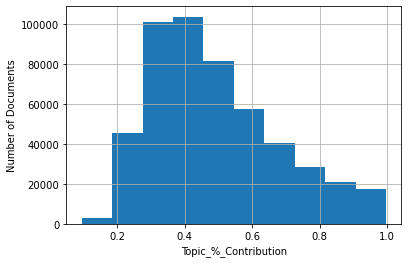

In [10]:
df_dominant_topic['Topic_Perc_Contrib'].hist()
plt.gca().set(ylabel='Number of Documents', xlabel='Topic_%_Contribution')

In [22]:
# what topics have the most number of documents
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values("Dominant_Topic")

,Dominant_Topic,Num Documents
8,0,19884
18,1,12258
14,2,15216
4,3,30528
23,4,4185
17,5,13390
5,6,29909
21,7,7940
15,8,14870
11,9,16432


In [23]:
df_topic_distribution.to_csv('full_sample/dominant_topic_distribution_train_sample.csv', index=False)

<AxesSubplot:xlabel='Dominant_Topic'>

<Figure size 2560x1120 with 0 Axes>

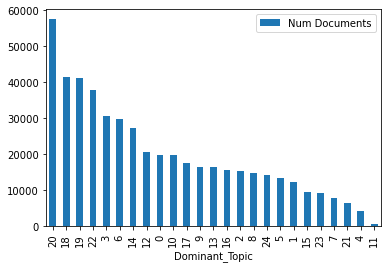

In [24]:
df = df_topic_distribution.set_index('Dominant_Topic')
plt.figure(figsize=(16,7), dpi=160)
df.plot(kind='bar')

In [25]:
def cluster_test(corpus, model):
    docs_with_1_topic = 0
    docs_with_multiple_topics = 0
    docs_with_no_topics = 0
    total_docs = 0
    for doc in corpus:
        topics = model.get_document_topics(doc, minimum_probability=0.20)
        total_docs += 1
        if len(topics) == 1:
            docs_with_1_topic += 1
        elif len(topics) > 1:
            docs_with_multiple_topics += 1
        else:
            docs_with_no_topics += 1
    print('Corpus assigned to a single topic:', (docs_with_1_topic / total_docs) * 100, '%')
    print('Corpus assigned to multiple topics:', (docs_with_multiple_topics / total_docs) * 100, '%')
    print('corpus assigned to no topics:', (docs_with_no_topics / total_docs) * 100, '%')

In [26]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=bestModel_25, texts=token_words_trigrams_lemm_sample, 
                                         dictionary=id2word, coherence='c_v')
    
cv_opt = coherence_model_lda.get_coherence()

cv_opt

0.5244064291108138

In [27]:
cluster_test(train_corpus_lemm_sample, bestModel_25)

Corpus assigned to a single topic: 44.4058 %
Corpus assigned to multiple topics: 54.369 %
corpus assigned to no topics: 1.2252 %


In [28]:
print('\nPerplexity: ', bestModel_25.log_perplexity(train_corpus_lemm_sample)) 


Perplexity:  -8.41478539526716
